# Setting Up


In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
import os
os.chdir("/content/gdrive/My Drive/COVID")
!pwd

/content/gdrive/My Drive/COVID


# Importing Libraries

In [44]:
from tensorflow.keras.models import Model , load_model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Importing Data


In [45]:
# setting important parameters/variables
data_dir = os.listdir("two/")
train_dir = "two/" + data_dir[0]
test_dir = "two/" + data_dir[1]
image_size = (150, 150)
Batch_size = 64

In [56]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_std_normalization = True,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = image_size,
                                               shuffle = True,
                                               batch_size = Batch_size,
                                               subset = "training",
                                               class_mode = "binary")

val_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = image_size,
                                               shuffle = True,
                                               batch_size = Batch_size,
                                               subset = "validation",
                                               class_mode = "binary")

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=image_size,
                                            batch_size=1,
                                            shuffle = False,
                                            seed = 42,
                                            class_mode="binary")
test_data.reset()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


# Setting Up Important Functions

In [7]:
def get_model(base_model_name):
  if base_model_name == "vgg16":
    base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
  elif base_model_name == "vgg19":
    base_model = VGG19(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
  elif base_model_name == "resnet50":
    base_model = ResNet50(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))

  base_model.trainable = False

  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(1, activation = "sigmoid"))

  

  return model

In [8]:
def plot_history(history, epochs):
  x = range(1, epochs)
  acc = history.history["acc"]
  val_acc = history.history["val_acc"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  plt.figure(figsize = (15, 5))
  plt.subplot(121)
  plt.plot(x, acc[1:], label = "Train_Acc")
  plt.plot(x, val_acc[1:], label = "Val_Acc")
  plt.title("Accuracy over " + str(epochs) + " Epochs", size = 15)
  plt.legend()
  plt.subplot(122)
  plt.plot(x, loss[1:], label = "Train_loss")
  plt.plot(x, val_loss[1:], label = "Val_loss")
  plt.title("Loss over " + str(epochs) + " Epochs", size = 15)
  plt.legend()
  plt.show()

In [9]:
def evaluate_model(model, test_data, plot_examples = True, no_of_examples = 5):
  test_data.reset()
  results = model.evaluate(test_data)

  print("Test Loss: ", results[0])
  print("Test Accuracy: ", results[1])

  if plot_examples:
    pred = model.predict(test_data)
    for index, probability in enumerate(pred):
        if index == no_of_examples:
          break
        image_path = test_dir + "/" + test_data.filenames[index]
        image = mpimg.imread(image_path)
        pixels = np.array(image)
        plt.imshow(pixels)        
        print("File: ", test_data.filenames[index])
        if probability > 0.5:
            plt.title("%.2f" % (probability[0]*100) + "% Normal")
        else:
            plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19")
        plt.show()

# Creating Models
## 1. VGG16 as Basemodel


In [64]:
vgg16_model = get_model("vgg16")
vgg16_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['acc'])
vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [65]:
history = vgg16_model.fit_generator(train_data, validation_data = val_data, epochs= 20)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
2/2 [==============================] - 19s 9s/step - loss: 0.8609 - acc: 0.4808 - val_loss: 0.3617 - val_acc: 0.8077
Epoch 2/20
2/2 [==============================] - 14s 7s/step - loss: 0.3995 - acc: 0.7885 - val_loss: 0.3507 - val_acc: 0.8077
Epoch 3/20
2/2 [==============================] - 19s 9s/step - loss: 0.2212 - acc: 0.9231 - val_loss: 0.1235 - val_acc: 1.0000
Epoch 4/20
2/2 [==============================] - 14s 7s/step - loss: 0.1562 - acc: 0.9519 - val_loss: 0.1223 - val_acc: 1.0000
Epoch 5/20
2/2 [==============================] - 14s 7s/step - loss: 0.1767 - acc: 0.9519 - val_loss: 0.0651 - val_acc: 1.0000
Epoch 6/20
2/2 [==============================] - 19s 9s/step - loss: 0.0809 - acc: 0.9808 - val_loss: 0.0626 - val_acc: 1.0000
Epoch 7/20
2/2 [==============================] - 14s 7s/step - loss: 0.0777 - acc: 0.9712 - val_loss: 0.1415 - val_acc: 0.8846
Epoch 8/20
2/2 [==============================] - 19s 9s/step - loss: 0.0627 - acc: 0.9904 - val_loss: 0

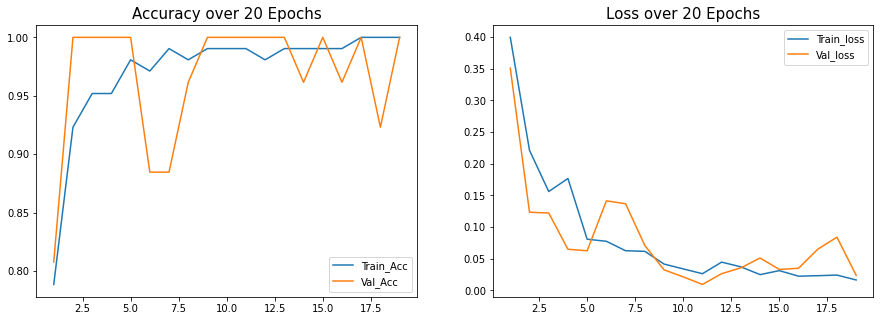

In [66]:
plot_history(history, 20)

18/18 [==============================] - 4s 235ms/step - loss: 0.0328 - acc: 1.0000
Test Loss:  0.0327523797750473
Test Accuracy:  1.0
File:  covid/nejmoa2001191_f3-PA.jpeg


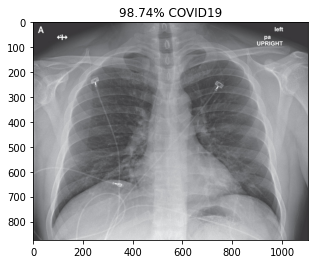

File:  covid/nejmoa2001191_f4.jpeg


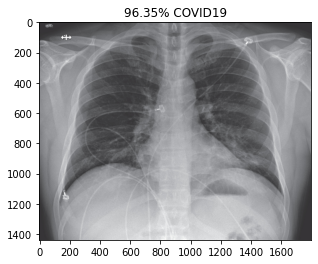

File:  covid/nejmoa2001191_f5-PA.jpeg


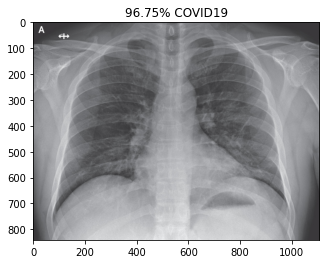

File:  covid/radiol.2020200490.fig3.jpeg


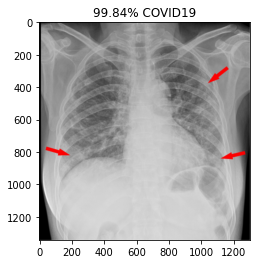

File:  covid/ryct.2020200028.fig1a.jpeg


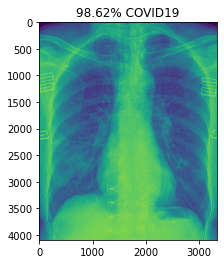

In [67]:
evaluate_model(vgg16_model, test_data)

## 2. VGG19 as Basemodel



In [35]:
vgg19_model = get_model("vgg19")
vgg19_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['acc'])
vgg19_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


In [36]:
history_vgg19 = vgg19_model.fit_generator(train_data, validation_data = val_data, epochs= 20)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
2/2 [==============================] - 17s 9s/step - loss: 0.9138 - acc: 0.5288 - val_loss: 0.2589 - val_acc: 0.9231
Epoch 2/20
2/2 [==============================] - 23s 11s/step - loss: 0.7217 - acc: 0.5962 - val_loss: 0.3383 - val_acc: 0.8077
Epoch 3/20
2/2 [==============================] - 17s 9s/step - loss: 0.3168 - acc: 0.8462 - val_loss: 0.2468 - val_acc: 0.8462
Epoch 4/20
2/2 [==============================] - 23s 11s/step - loss: 0.2969 - acc: 0.8462 - val_loss: 0.3087 - val_acc: 0.8462
Epoch 5/20
2/2 [==============================] - 17s 9s/step - loss: 0.2721 - acc: 0.8654 - val_loss: 0.0738 - val_acc: 1.0000
Epoch 6/20
2/2 [==============================] - 23s 11s/step - loss: 0.0812 - acc: 0.9808 - val_loss: 0.0353 - val_acc: 1.0000
Epoch 7/20
2/2 [==============================] - 17s 9s/step - loss: 0.1421 - acc: 0.9519 - val_loss: 0.0529 - val_acc: 1.0000
Epoch 8/20
2/2 [==============================] - 23s 12s/step - loss: 0.1178 - acc: 0.9615 - val_los

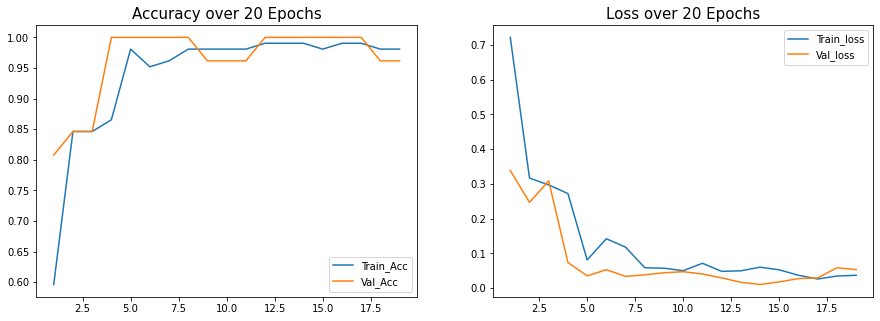

In [37]:
plot_history(history_vgg19, 20)

18/18 [==============================] - 5s 276ms/step - loss: 0.0340 - acc: 1.0000
Test Loss:  0.033952634781599045
Test Accuracy:  1.0
File:  covid/nejmoa2001191_f3-PA.jpeg


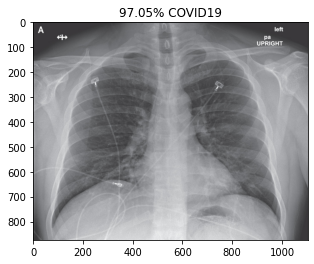

File:  covid/nejmoa2001191_f4.jpeg


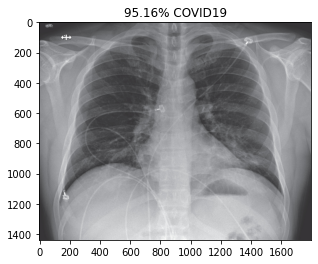

File:  covid/nejmoa2001191_f5-PA.jpeg


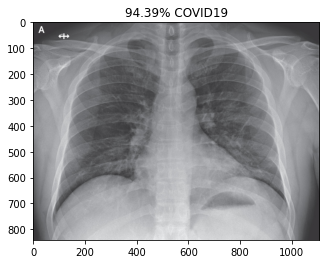

File:  covid/radiol.2020200490.fig3.jpeg


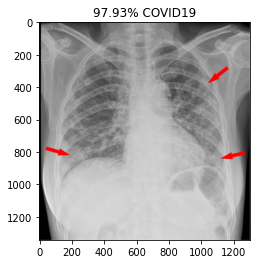

File:  covid/ryct.2020200028.fig1a.jpeg


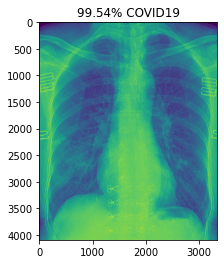

In [58]:
evaluate_model(vgg19_model, test_data)

## 3. Resnet50 as Basemodel

In [70]:
res_model = get_model("resnet50")
res_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['acc'])
res_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
_________________________________________________________________


In [71]:
history_res = res_model.fit_generator(train_data, validation_data = val_data, epochs= 20)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
2/2 [==============================] - 7s 3s/step - loss: 2.2354 - acc: 0.4423 - val_loss: 2.0008 - val_acc: 0.5385
Epoch 2/20
2/2 [==============================] - 6s 3s/step - loss: 1.5943 - acc: 0.5192 - val_loss: 1.5379 - val_acc: 0.4615
Epoch 3/20
2/2 [==============================] - 6s 3s/step - loss: 1.4471 - acc: 0.4615 - val_loss: 0.6917 - val_acc: 0.4615
Epoch 4/20
2/2 [==============================] - 7s 4s/step - loss: 0.6926 - acc: 0.5385 - val_loss: 1.0086 - val_acc: 0.5385
Epoch 5/20
2/2 [==============================] - 6s 3s/step - loss: 1.0573 - acc: 0.5385 - val_loss: 0.8478 - val_acc: 0.5385
Epoch 6/20
2/2 [==============================] - 6s 3s/step - loss: 0.7491 - acc: 0.5481 - val_loss: 0.6119 - val_acc: 0.4615
Epoch 7/20
2/2 [==============================] - 7s 4s/step - loss: 0.7535 - acc: 0.4712 - val_loss: 0.7979 - val_acc: 0.4615
Epoch 8/20
2/2 [==============================] - 6s 3s/step - loss: 0.7895 - acc: 0.4615 - val_loss: 0.5122 - 

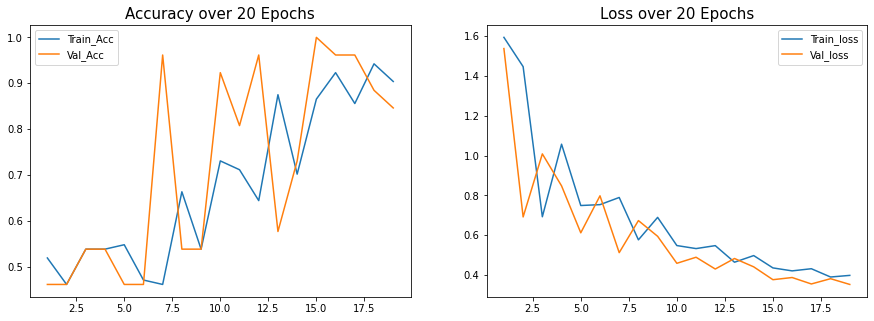

In [72]:
plot_history(history_res, 20)

18/18 [==============================] - 2s 116ms/step - loss: 0.4426 - acc: 0.9444
Test Loss:  0.44257330894470215
Test Accuracy:  0.9444444179534912
File:  covid/nejmoa2001191_f3-PA.jpeg


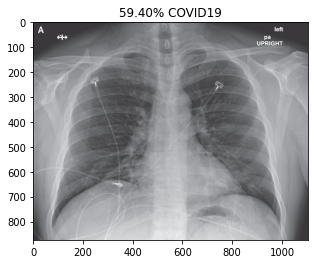

File:  covid/nejmoa2001191_f4.jpeg


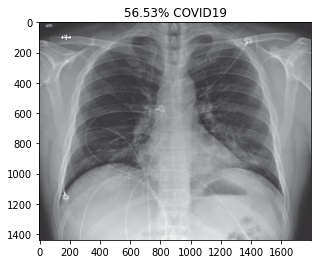

File:  covid/nejmoa2001191_f5-PA.jpeg


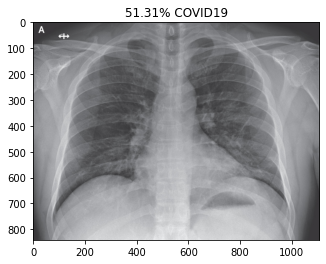

File:  covid/radiol.2020200490.fig3.jpeg


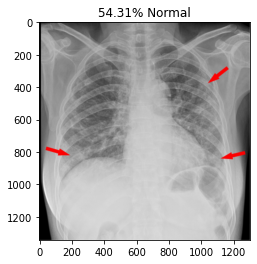

File:  covid/ryct.2020200028.fig1a.jpeg


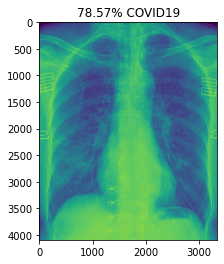

In [73]:
evaluate_model(res_model, test_data)

# Conclusion
 Transfer Learning is a very powerful tool in the arsenal of Deep learning as it allows to harnes the power of already trained deep nets and create model with very little data. The already trained models acts as feature extractors and then pass those features onto the dense layers to generate predictions.